In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
import json
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
from gym import spaces
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import accuracy_score



from itertools import count

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from sklearn.model_selection import train_test_split

from collections import namedtuple

import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def sort_by_x(X):
    for i,data in enumerate(X):
        middle_point = int(len(data)/2)
        x = data[:middle_point]
        y = data[middle_point:]
        sorted_xy = np.asarray([[a,x] for a,x in sorted(zip(data[:middle_point],data[middle_point:]))])
        new_data = np.concatenate((sorted_xy[:,0], sorted_xy[:,1]), axis=None)
        X[i] = new_data
    return X

In [40]:
N_DISCRETE_ACTIONS = 5 # Number of networks

class NAS_Env(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data_path, reward_penalty=0.01, naction_ending=5, step_sampling=False):
        super(NAS_Env, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
        
        self.data_path = data_path
        self.X_train, self.y_train, self.X_test, self.y_test, self.r_train, self.r_test = self.load_data()
    
        self.reward_range = (-1,1)
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=-5, high=5, shape=(2, 80), dtype=np.float16)
        
        self.reward_penalty = reward_penalty
        self.naction_ending = naction_ending
        self.step_sampling = step_sampling
        
        self.set_train_mode()
        
        self.current_dataset_id  = 0
        
        self.set_current_dataset()
        
        self.current_mask = []
        self.current_step = 1
        self.current_observation = self.get_observation()
        #print("Current observation", self.current_observation)
        
        self.history_action = []
        self.history_rewards = []
        self.history_max_possible_rewards = []
        
        
        
    def set_train_mode(self):
        
        self.datasets = self.X_train
        self.ys = self.y_train
        self.rewards = self.r_train
        
    def set_test_mode(self):
        
        self.datasets = self.X_test
        self.ys = self.y_test
        self.rewards = self.r_test 
        
    def set_current_dataset(self):
        
        self.current_dataset = self.datasets[self.current_dataset_id].reshape((2,80))
        self.current_ys = self.ys[self.current_dataset_id]
        self.current_rewards = self.rewards[self.current_dataset_id]   
         
    def step(self, action):
        
        #print("Action:",action)
        
        done = (self.current_step >= self.naction_ending and len(np.unique(
            self.history_action[-self.naction_ending:])) == 1) or (self.current_step == self.current_dataset.shape[1])
        
        
        full_reward = self.current_rewards[action]
        discounted_reward = full_reward * np.exp(-self.current_step * self.reward_penalty)
        
        max_possible_reward = max(self.current_rewards)
        discounted_max_possible_reward = max_possible_reward * np.exp(-self.current_step * self.reward_penalty)
        
        self.history_action.append(action)
        self.history_rewards.append(discounted_reward)
        self.history_max_possible_rewards.append(discounted_max_possible_reward)
        
        
        self.current_step +=1
        #print(self.current_step)
        self.current_observation = self.get_observation()
        #print("Current observation", self.current_observation)
        
        return self.current_observation, discounted_reward, done, ""
        
         
    def get_observation(self):
         # Mask
        step_mask = np.zeros(self.current_dataset.shape[1])
        step_mask[:self.current_step] = 1.0
        
        if self.step_sampling:
            available_idxs = list(set(range(len(step_mask))).difference(set(self.current_mask)))
            chosen_idx = np.random.choice(available_idxs)
            self.current_mask.append(chosen_idx)
        else:
            self.current_mask = list(range(self.current_step))
        
        step_mask[self.current_mask] = 1.0
        
        new_obs = copy.deepcopy(self.current_dataset)
        new_obs[0, :] = new_obs[0,:] * step_mask
        new_obs[1, :] = new_obs[1,:] * step_mask
        return new_obs
         
    # Execute one time step within the environment
    
    def reset(self, train = False):
        
        if train == True:
            self.set_train_mode()
        else:
            self.set_test_mode()
            
        self.current_dataset_id  = random.randint(0, self.datasets.shape[0]-1)
        self.set_current_dataset()
        
        self.current_mask = []
        self.current_step = 1
        self.current_observation = self.get_observation()
        
        self.history_action = []
        self.history_rewards = []
        self.history_max_possible_rewards = []
        
        
  
        
    # Reset the state of the environment to an initial state
    
    def render(self, mode='human', close=False):
        print("lol")
    # Render the environment to the screen
    
    def load_data(self):
        
        with open(self.data_path, "r") as f:
            data = json.load(f)
        # # keep only winning networks
        X, y, r = [], [], []
        n_networks = len(np.unique(data["actions"]))
        n_func = len(data["states"]) // n_networks
        # # print(n_networks, n_func)
        for f_i in range(n_func):
            scores_i = []
            actions_i = []
            for n_i in range(n_networks):
                i = f_i * n_networks + n_i
                scores_i.append(data["scores"][i])
                actions_i.append(data["actions"][i])
            X.append(data["states"][i])
            y.append(actions_i)
            r.append(scores_i)
        X = np.array(X)
        y = np.array(y)
        r = np.array(r)
        
        print(X.shape)
        print(y.shape)
        print(r.shape)
        # fix action ordering
        idx_order = np.argsort(y[0])
        y = y[:, idx_order]
        r = r[:, idx_order]
        idxs = np.arange(X.shape[0])
        test_split = int(0.33 * len(idxs))
        np.random.shuffle(idxs)
        
        idxs_train = idxs[:-test_split]
        idxs_test = idxs[-test_split:]
        
        X_train = X[idxs_train]
        y_train = y[idxs_train]
        r_train = r[idxs_train]
        
        X_test = X[idxs_test]
        y_test = y[idxs_test]
        r_test = r[idxs_test]
        
        return sort_by_x(X_train), y_train, sort_by_x(X_test), y_test, r_train, r_test 
    

In [52]:
data_path = "polynome_ready_for_training.json"
SHUFFLE_SAMPLES = True

env = NAS_Env(data_path, reward_penalty=0.3, naction_ending=5, step_sampling=SHUFFLE_SAMPLES)

(900, 160)
(900, 5)
(900, 5)


In [53]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        else:
            return False
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        return True

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
    def reset(self):
        self.memory = []
        self.position = 0 

In [54]:
class DQN(nn.Module):
    def __init__(self, env):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(env.observation_space.shape[0]* env.observation_space.shape[1], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, env.action_space.n)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [55]:
policy_net = DQN(env)
target_net = DQN(env)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=160, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

In [56]:
optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(100000)

In [57]:
def get_action(state):
    actions = policy_net(state)
    return torch.argmax(actions)


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
   
    non_final_next_states = torch.reshape(non_final_next_states,(int(non_final_next_states.shape[0]/2), 160))
    
    
    state_batch = torch.reshape(torch.cat(batch.state),(BATCH_SIZE, 160))
    action_batch = torch.reshape(torch.stack(batch.action), (BATCH_SIZE,1))
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [58]:
num_episodes = 1000
TARGET_UPDATE = 5
BATCH_SIZE = 20
GAMMA = 0.999

episode_predicted_networks = []
episode_best_true_networks = []
episode_true_networks_r2 = []
episode_rewards = []
episode_max_possible_rewards = []
episode_durations = []


for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset(train=True)
    
    
    state = torch.from_numpy(env.current_observation)
    for i in range(80):
        action = get_action(state.flatten())
        _, reward, done, _ = env.step(action)
        reward = torch.tensor([reward])

        next_state = torch.from_numpy(env.current_observation)
        # Observe new state
        
        if done:
            next_state = None

        # Store the transition in memory
        
        success_push = memory.push(state,
                    action, 
                    next_state, 
                    reward)
        if success_push == False:
            print(i)
        

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model() 
        
        if done:
            
            episode_predicted_network = env.history_action[-2].numpy()
            episode_best_true_network = np.argmax(env.current_rewards)
            episode_reward = sum(env.history_rewards)
            episode_max_possible_reward = sum(env.history_max_possible_rewards)
            
            episode_predicted_networks.append(episode_predicted_network)
            episode_true_networks_r2.append(env.current_rewards)
            episode_best_true_networks.append(episode_best_true_network)
            episode_rewards.append(episode_reward)
            episode_max_possible_rewards.append(episode_max_possible_reward)
            episode_durations.append(i + 1) 
            
            #print("Final network chosen:", predicted_network)
            #print("Episode total reward:",sum(env.history_rewards))
            #print("Episode max possible reward", sum(env.history_max_possible_rewards))
            #print("episode done at step", i)
            #print("True rewards", env.current_rewards)
            #episode_durations.append(i + 1)
            #print()
            break
            
        
            
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

Complete


In [59]:
top_k_accuracy_score(episode_predicted_networks, episode_true_networks_r2, k=2, labels = [0,1,2,3,4])

0.752

In [60]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

filter_size = 11
pad = int((filter_size - 1)/2)

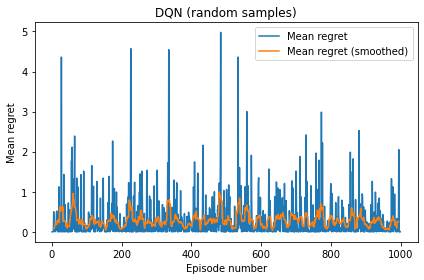

In [61]:
x_steps = np.linspace(0, num_episodes -1, num= num_episodes, dtype = int)
plt.plot(x_steps, np.array(episode_max_possible_rewards) - np.array(episode_rewards), label="Mean regret")
plt.plot(x_steps[pad:-pad], moving_average(np.array(episode_max_possible_rewards) - np.array(episode_rewards), filter_size), label="Mean regret (smoothed)")
envtype = "random" if SHUFFLE_SAMPLES else "sequential"
plt.title(f"DQN ({envtype} samples)")
plt.xlabel("Episode number")
plt.ylabel("Mean regret")
plt.legend()
plt.tight_layout()

plt.savefig(f"./figures/regret-DQN-{envtype}.pdf", dpi=1000)

plt.show()

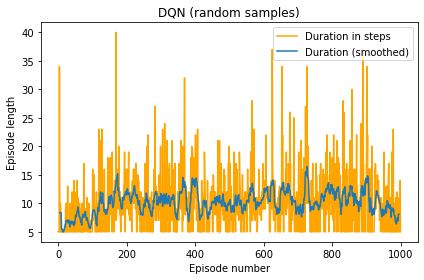

In [62]:
plt.plot(x_steps, episode_durations,c='orange', label="Duration in steps")
plt.plot(x_steps[pad:-pad], moving_average(episode_durations, filter_size), label="Duration (smoothed)")
envtype = "random" if SHUFFLE_SAMPLES else "sequential"
plt.title(f"DQN ({envtype} samples)")
plt.xlabel("Episode number")
plt.ylabel("Episode length")
plt.legend()
plt.tight_layout()

plt.savefig(f"./figures/duration-DQN-{envtype}.pdf", dpi=1000)
plt.show()